In [2]:
import numpy as np
import pandas as pd
import pysam

from tensorflow.keras import models, layers, losses, preprocessing as kprocessing
from tensorflow.keras import backend as K
import gensim

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

In [31]:
np.random.seed(0)

In [42]:
data = pd.read_csv('../Downloads/training.csv')

In [43]:
ref = pysam.FastaFile('male.hg19.fa') # reference genome

In [44]:
nonpredictors = ['enhancer_chrom', 'enhancer_start', 'enhancer_end', 
                 'promoter_chrom', 'promoter_start', 'promoter_end', 
                 'window_chrom', 'window_start', 'window_end', 'window_name', 
                 'active_promoters_in_window', 'interactions_in_window', 
                 'enhancer_distance_to_promoter', 'bin', 'label',
                 'promoter_seq', 'enhancer_seq'] 

In [45]:
def fetch_seq(start, end, region):
    seq = ref.fetch(start=start - 1,
                    end=end,
                    region=region)
    return seq.lower()

data['enhancer_seq'] = data.apply(lambda x: fetch_seq(x['enhancer_start'],
                                                x['enhancer_end'],
                                                x['enhancer_chrom']),
                                  axis=1)

mean      424.558867
median    243.000000
std       530.822479
Name: enhancer_seq, dtype: float64


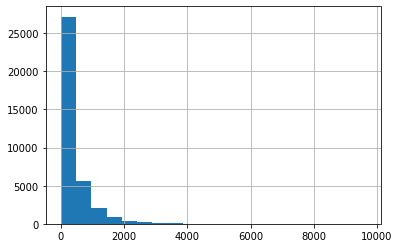

In [46]:
data['enhancer_seq'].apply(len).hist(bins=20)
print(data['enhancer_seq'].apply(len).agg(['mean', 'median', 'std']))

In [47]:
data['promoter_seq'] = data.apply(lambda x: fetch_seq(x['promoter_start'],
                                                x['promoter_end'],
                                                x['promoter_chrom']),
                                  axis=1)

mean      1245.444745
median    1152.000000
std        676.689914
Name: promoter_seq, dtype: float64


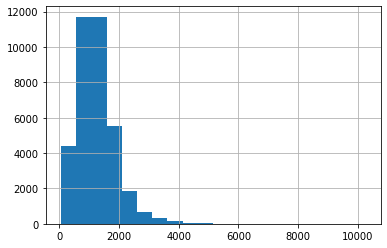

In [48]:
data['promoter_seq'].apply(len).hist(bins=20)
print(data['promoter_seq'].apply(len).agg(['mean', 'median', 'std']))

In [49]:
data[(data.promoter_seq.apply(len) > 2500) |
    (data.enhancer_seq.apply(len) > 2500)].shape[0] / data.shape[0]

0.05262725779967159

In [50]:
def split_to_kmers(x, k=5):
    return [x[i:min(i+k, len(x))] for i in range(0, len(x), k)]

In [51]:
data['promoter_seq_words'] = data['promoter_seq'].apply(split_to_kmers)
data['enhancer_seq_words'] = data['enhancer_seq'].apply(split_to_kmers)

# Train/valid/test splitting & upsampling function 

In [52]:
data = data.set_index(['enhancer_name', 'promoter_name'])

In [53]:
train_valid, test = train_test_split(data, test_size=0.1, random_state=0, stratify=data['label'])
train, valid = train_test_split(train_valid, test_size=0.2, random_state=0, stratify=train_valid['label'])

<AxesSubplot:>

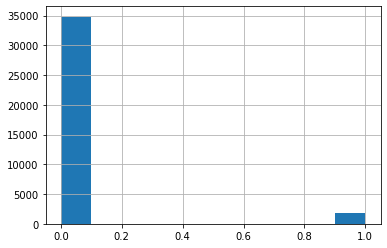

In [54]:
data.label.hist()

In [55]:
def upsample(data, label, n_times=6, rs=0):
    minor_class = data[data.label == label]
    minor_class = minor_class.sample(minor_class.shape[0] * n_times, 
                                     replace=True, random_state=rs)
    new_data = pd.concat((data, minor_class)).sample(frac=1, 
                                                     random_state=rs) # concat and shuffle the data
    return new_data

In [56]:
train_valid_upsampled = upsample(train_valid, 1)
train_upsampled = upsample(train, 1)

In [57]:
labels = {
    'train': train['label'],
    'train_upsampled': train_upsampled['label'],
    'test': test['label'],
    'valid': valid['label'],
    'train_valid': train_valid['label'],
    'train_valid_upsampled': train_valid_upsampled['label']
}

In [58]:
to_drop = nonpredictors + ['promoter_seq_words', 'enhancer_seq_words']
tf_x = {
    'train': train.drop(to_drop, axis=1),
    'train_upsampled': train_upsampled.drop(to_drop, axis=1),
    'test': test.drop(to_drop, axis=1),
    'valid': valid.drop(to_drop, axis=1),
    'train_valid': train_valid.drop(to_drop, axis=1),
    'train_valid_upsampled': train_valid_upsampled.drop(to_drop, axis=1)
}

# TargetFinder model with/without upsampling

In [59]:
est_tf = GradientBoostingClassifier(n_estimators = 4000, learning_rate = 0.1,
                                       max_depth = 5, max_features = 'log2', 
                                       random_state = 0)

In [60]:
est_tf.fit(tf_x['train'], labels['train'])
f1_score(labels['valid'],
        est_tf.predict(tf_x['valid']))

0.8389380530973451

In [61]:
est_tf.fit(tf_x['train_upsampled'], labels['train_upsampled'])
f1_score(labels['valid'],
        est_tf.predict(tf_x['valid']))

0.8468158347676419

In [65]:
est_tf.fit(tf_x['train_valid_upsampled'], labels['train_valid_upsampled'])
f1_score(labels['test'],
        est_tf.predict(tf_x['test']))

0.8528528528528528

In [86]:
precision_score(labels['test'], est_tf.predict(tf_x['test'])),\
recall_score(labels['test'], est_tf.predict(tf_x['test']))

(0.8930817610062893, 0.8160919540229885)

# Sequences encoding

In [62]:
class dna2vec:
    def __init__(self, s=20, min_count=2, window=2):
        self.size = s
        self.w2v = gensim.models.Word2Vec(size=s, 
                                            window=window, 
                                            min_count=min_count, 
                                            workers=7)
    
    def fit(self, corpus):
        self.w2v.build_vocab(corpus)
        self.w2v.train(corpus,
                       total_examples=self.w2v.corpus_count,
                       epochs=30,
                       report_delay=1)
        self.w2v.init_sims(replace=True)

# GB + sequences of size 20

In [63]:
promoters_dna2vec = dna2vec()
promoters_dna2vec.fit(train_valid.promoter_seq_words.values)
enhancers_dna2vec = dna2vec()
enhancers_dna2vec.fit(train_valid.enhancer_seq_words.values)

In [64]:
def transform_to_avg_vec(corpus, model, name):
    s = model.size
    vectors = np.array([
            np.mean([model.w2v.wv[w] for w in sent if w in model.w2v.wv] or [np.zeros(s)], 
                    axis=0)
            for sent in corpus
        ])
    dataset = dict(zip([f'{name}_{i}' for i in range(s)], vectors.T))
    return pd.DataFrame(dataset)

In [66]:
seq_avg_x = {}
for name, df in zip(
    ['train', 'valid', 'test', 'train_valid', 'train_upsampled', 'train_valid_upsampled'],
    [train, valid, test, train_valid, train_upsampled, train_valid_upsampled] ):
    promoters = transform_to_avg_vec(df.promoter_seq_words.values,
                                     promoters_dna2vec,
                                     'promoter')
    enhancers = transform_to_avg_vec(df.enhancer_seq_words.values,
                                     enhancers_dna2vec,
                                     'enhancer')
    seq_avg_x[name] = pd.concat((promoters, enhancers), axis=1)

In [69]:
best_params = {'n_estimators': -1,
               'max_depth': -1,
               'max_features': -1}
best_f1 = 0

for n_est in [2000, 4000]:
    for md in range(4, 6):
        for mf in ['log2', 'sqrt']:
            estimator = GradientBoostingClassifier(n_estimators = n_est, 
                                                   learning_rate = 0.1,
                                                   max_depth = md,
                                                   max_features=mf,
                                                   random_state = 0)
            estimator.fit(seq_avg_x['train'], labels['train'])
            preds_valid = estimator.predict(seq_avg_x['valid'])
            f1 = f1_score(labels['valid'], preds_valid)
            print(f1)
            if f1 > best_f1:
                best_params['n_estimators'] = n_est
                best_params['max_depth'] = md
                best_params['max_features'] = mf
                best_f1 = f1

0.27135678391959794
0.28776978417266186
0.26566416040100255
0.28501228501228504
0.28921568627450983
0.3054892601431981
0.2729528535980149
0.27860696517412936


In [73]:
best_params, best_f1

({'n_estimators': 4000, 'max_depth': 4, 'max_features': 'sqrt'},
 0.3054892601431981)

# GB + sequences of size 20 + upsampling

In [75]:
estimator_seq_avg = GradientBoostingClassifier(learning_rate = 0.1, random_state = 0,
                                              **best_params)
estimator_seq_avg.fit(seq_avg_x['train_upsampled'], labels['train_upsampled'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=4000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [76]:
f1_score(labels['valid'], estimator_seq_avg.predict(seq_avg_x['valid']))

0.3118040089086859

# GB + sequences of size 30

In [77]:
promoters_dna2vec_30 = dna2vec(s=30)
promoters_dna2vec_30.fit(train_valid.promoter_seq_words.values)
enhancers_dna2vec_30 = dna2vec(s=30)
enhancers_dna2vec_30.fit(train_valid.enhancer_seq_words.values)

In [78]:
seq_avg_x_30 = {}
for name, df in zip(
    ['train', 'valid', 'test', 'train_valid', 'train_upsampled', 'train_valid_upsampled'],
    [train, valid, test, train_valid, train_upsampled, train_valid_upsampled] ):
    promoters = transform_to_avg_vec(df.promoter_seq_words.values,
                                     promoters_dna2vec_30,
                                     'promoter')
    enhancers = transform_to_avg_vec(df.enhancer_seq_words.values,
                                     enhancers_dna2vec_30,
                                     'enhancer')
    seq_avg_x_30[name] = pd.concat((promoters, enhancers), axis=1)

In [80]:
best_params_30 = {'n_estimators': -1,
               'max_depth': -1,
               'max_features': -1}
best_f1_30 = 0

for n_est in [2000, 4000]:
    for md in range(4, 6):
        for mf in ['log2', 'sqrt']:
            estimator = GradientBoostingClassifier(n_estimators = n_est, 
                                                   learning_rate = 0.1,
                                                   max_depth = md,
                                                   max_features=mf,
                                                   random_state = 0)
            estimator.fit(seq_avg_x_30['train'], labels['train'])
            preds_valid = estimator.predict(seq_avg_x_30['valid'])
            f1 = f1_score(labels['valid'], preds_valid)
            print(f1)
            if f1 > best_f1_30:
                best_params_30['n_estimators'] = n_est
                best_params_30['max_depth'] = md
                best_params_30['max_features'] = mf
                best_f1_30 = f1

0.2772277227722772
0.2766990291262136
0.28428927680798005
0.29207920792079206
0.2743142144638404
0.2829736211031175
0.29484029484029484
0.30731707317073176


In [82]:
best_params_30, best_f1_30

({'n_estimators': 4000, 'max_depth': 5, 'max_features': 'sqrt'},
 0.30731707317073176)

# GB + sequences of size 30 + upsampling

In [83]:
estimator_seq_avg_30 = GradientBoostingClassifier(learning_rate = 0.1, random_state = 0,
                                              **best_params_30)
estimator_seq_avg_30.fit(seq_avg_x_30['train_upsampled'], labels['train_upsampled'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=4000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [84]:
f1_score(labels['valid'], estimator_seq_avg_30.predict(seq_avg_x_30['valid']))

0.3410138248847926

# Best GB + sequences model score

In [85]:
estimator_seq_avg_30.fit(seq_avg_x_30['train_valid_upsampled'], 
                         labels['train_valid_upsampled'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=4000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [88]:
f1_score(labels['test'],
        estimator_seq_avg_30.predict(seq_avg_x_30['test']))

0.359375

In [89]:
precision_score(labels['test'], estimator_seq_avg_30.predict(seq_avg_x_30['test'])),\
recall_score(labels['test'], estimator_seq_avg_30.predict(seq_avg_x_30['test']))

(0.5609756097560976, 0.26436781609195403)

# Combined: best GB & TF

In [98]:
est_tf_trainonly = GradientBoostingClassifier(n_estimators = 4000, learning_rate = 0.1,
                                       max_depth = 5, max_features = 'log2', 
                                       random_state = 0)
est_tf_trainonly.fit(tf_x['train_upsampled'],
                     labels['train_upsampled'])
valid_tf_preds = est_tf_trainonly.predict_proba(tf_x['valid'])

In [99]:
est_seq_avg30_trainonly = GradientBoostingClassifier(learning_rate = 0.1, random_state = 0,
                                              **best_params_30)
est_seq_avg30_trainonly.fit(seq_avg_x_30['train_upsampled'],
                            labels['train_upsampled'])
valid_seq_avg30_preds = est_seq_avg30_trainonly.predict_proba(seq_avg_x_30['valid'])

In [298]:
est_combined_seq_avg = GradientBoostingClassifier(learning_rate=0.1, random_state=0,
                                                  n_estimators=30, max_depth=2)
est_combined_seq_avg.fit(np.concatenate((valid_tf_preds, valid_seq_avg30_preds), axis=1),
                        labels['valid'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [299]:
prob_tf = est_tf.predict_proba(tf_x['test'])
prob_seq_avg_30 = estimator_seq_avg_30.predict_proba(seq_avg_x_30['test'])
combined_preds = est_combined_seq_avg.predict(np.concatenate((prob_tf, prob_seq_avg_30), axis=1))

In [300]:
f1_score(labels['test'],
        combined_preds)

0.8511904761904763

In [301]:
precision_score(labels['test'], combined_preds), recall_score(labels['test'], combined_preds)

(0.8827160493827161, 0.8218390804597702)

# Fitting NN

In [180]:
class dna_tokenizer:
    def __init__(self, sent_size=500):
        self.size = sent_size
        self.tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                                                    oov_token="NaN")
        
    def fit(self, corpus):
        self.tokenizer.fit_on_texts(list(map(lambda x: ' '.join(x),
                                             corpus)))
        dic_vocabulary = self.tokenizer.word_index
        
    def transform(self, corpus):
        lst_text2seq = self.tokenizer.texts_to_sequences(
            list(map(lambda x: ' '.join(x), corpus))
        )
        res = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=self.size, padding="post", truncating="post")
        return res
    
    def vocabulary(self):
        return self.tokenizer.word_index

In [181]:
def get_embeddings_matrix(w2v, tokenizer):
    embeddings = np.zeros((len(tokenizer.vocabulary())+1, w2v.size))
    for word, idx in tokenizer.vocabulary().items():
        try:
            embeddings[idx] =  w2v.w2v.wv[word]
        except:
            pass
    return embeddings

In [182]:
def filter_seq_length(df, l=2500):
    return df[(df.promoter_seq.apply(len) <= l) &
             (df.enhancer_seq.apply(len) <= l)]

In [183]:
train_valid_nn = filter_seq_length(train_valid)

In [184]:
promoters_tokenizer = dna_tokenizer()
promoters_tokenizer.fit(train_valid_nn.promoter_seq_words.values)
enhancers_tokenizer = dna_tokenizer()
enhancers_tokenizer.fit(train_valid_nn.enhancer_seq_words.values)

In [185]:
promoters_embeddins = get_embeddings_matrix(promoters_dna2vec_30, 
                                            promoters_tokenizer)
enhancers_embeddins = get_embeddings_matrix(enhancers_dna2vec_30, 
                                            enhancers_tokenizer)

In [204]:
seq_nn_x = {}
labels_nn = {}

for name, df in zip(
    ['train', 'valid', 'test', 'train_valid', 'train_upsampled', 'train_valid_upsampled'],
    [train, valid, test, train_valid, train_upsampled, train_valid_upsampled] ):
    df_filtered = filter_seq_length(df)
    promoters = promoters_tokenizer.transform(df_filtered['promoter_seq_words'].values)
    enhancers = enhancers_tokenizer.transform(df_filtered['enhancer_seq_words'].values)
    seq_nn_x[name] = [promoters, enhancers]
    labels_nn[name] = df_filtered['label']

In [187]:
def get_model(emb_prom, emb_enh, sent_size=500, activation='relu', n_filters=4):
    
    # input
    proms = layers.Input(shape=(sent_size,), name='promoters')
    enhs = layers.Input(shape=(sent_size,), name='enhancers')
    
    # embedding&convolution for promoters
    x_prom = layers.Embedding(input_dim=emb_prom.shape[0],  
                              output_dim=emb_prom.shape[1], 
                              weights=[emb_prom],
                              input_length=sent_size, trainable=False)(proms)
    x_prom = layers.Conv1D(filters=n_filters, kernel_size=100, activation=activation)(x_prom)
    x_prom = layers.Conv1D(filters=n_filters, kernel_size=100, activation=activation)(x_prom)
    x_prom = layers.Flatten()(x_prom)
    prom_model = models.Model(proms, x_prom)

    # embedding&convolution for enhancers
    x_enh = layers.Embedding(input_dim=emb_enh.shape[0],  
                         output_dim=emb_enh.shape[1], 
                         weights=[emb_enh],
                         input_length=sent_size, trainable=False)(enhs)
    x_enh = layers.Conv1D(filters=n_filters, kernel_size=100, activation=activation)(x_enh)
    x_enh = layers.Conv1D(filters=n_filters, kernel_size=100, activation=activation)(x_enh)
    x_enh = layers.Flatten()(x_enh)
    enh_model = models.Model(enhs, x_enh)

    # convolution for enhancers and promoters together
    combined = layers.Concatenate()([prom_model.output, enh_model.output])
    x = layers.Reshape((2, n_filters * (sent_size - 200 + 2), 1))(combined)
    x = layers.Conv2D(filters=n_filters, kernel_size=(2, 100), activation=activation)(x)
    x = layers.Conv2D(filters=n_filters, kernel_size=(1, 100), activation=activation)(x)

    # dense layers to get the final result
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation=activation)(x)
    y_out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([prom_model.input, enh_model.input], y_out)
    model.compile(loss=losses.BinaryCrossentropy(),
                  optimizer='adam', metrics=['accuracy'])

    return model

## ReLU activation, 4 filters

In [212]:
m1 = get_model(promoters_embeddins, enhancers_embeddins)

In [189]:
m1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
promoters (InputLayer)          [(None, 500)]        0                                            
__________________________________________________________________________________________________
enhancers (InputLayer)          [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 30)      40860       promoters[0][0]                  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 30)      40980       enhancers[0][0]                  
____________________________________________________________________________________________

In [213]:
f1_scores_1 = []
acc = []
for i in range(5):
    history_1 = m1.fit(
                    x=seq_nn_x['train'],
                    y=labels_nn['train'],
                    validation_data=(seq_nn_x['valid'], labels_nn['valid']),
                    epochs=1, batch_size=8)
    acc.append((history_1.history['acc'], history_1.history['val_acc']))
    train_pred = m1.predict(seq_nn_x['train'])
    valid_pred = m1.predict(seq_nn_x['valid'])
    f1_scores_1.append((
        f1_score(labels_nn['train'], train_pred > 0.5 ),
        f1_score(labels_nn['valid'], valid_pred > 0.5)))

Train on 24914 samples, validate on 6253 samples
24914/24914 [==============================] - 127s 5ms/sample - loss: 0.1933 - acc: 0.9556 - val_loss: 0.1838 - val_acc: 0.9552
Train on 24914 samples, validate on 6253 samples
24914/24914 [==============================] - 125s 5ms/sample - loss: 0.1805 - acc: 0.9556 - val_loss: 0.1717 - val_acc: 0.9551
Train on 24914 samples, validate on 6253 samples
24914/24914 [==============================] - 126s 5ms/sample - loss: 0.1655 - acc: 0.9565 - val_loss: 0.1634 - val_acc: 0.9554
Train on 24914 samples, validate on 6253 samples
24914/24914 [==============================] - 134s 5ms/sample - loss: 0.1545 - acc: 0.9576 - val_loss: 0.1631 - val_acc: 0.9557
Train on 24914 samples, validate on 6253 samples
24914/24914 [==============================] - 131s 5ms/sample - loss: 0.1528 - acc: 0.9583 - val_loss: 0.1624 - val_acc: 0.9555


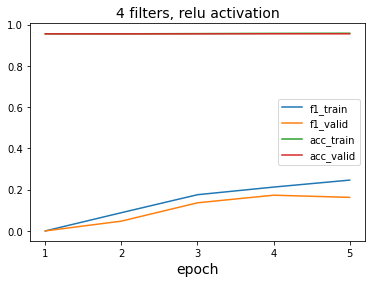

In [235]:
plt.plot(range(5), list(zip(*f1_scores_1))[0], label='f1_train')
plt.plot(range(5), list(zip(*f1_scores_1))[1], label='f1_valid')
plt.plot(range(5), list(zip(*acc))[0], label='acc_train')
plt.plot(range(5), list(zip(*acc))[1], label='acc_valid')
plt.xlabel('epoch', size=14)
plt.xticks(range(5), range(1, 6))
plt.title('4 filters, relu activation', size=14)
plt.legend()
plt.show()

## ReLU activation, 4 filters, upsampled

In [218]:
m2 = get_model(promoters_embeddins, enhancers_embeddins)

In [219]:
f1_scores_2 = []
acc_2 = []
for i in range(5):
    history = m2.fit(
                    x=seq_nn_x['train_upsampled'],
                    y=labels_nn['train_upsampled'],
                    validation_data=(seq_nn_x['valid'], labels_nn['valid']),
                    epochs=1, batch_size=8)
    acc_2.append((history.history['acc'], history.history['val_acc']))
    train_pred = m2.predict(seq_nn_x['train_upsampled'])
    valid_pred = m2.predict(seq_nn_x['valid'])
    f1_scores_2.append((
        f1_score(labels_nn['train_upsampled'], train_pred > 0.5 ),
        f1_score(labels_nn['valid'], valid_pred > 0.5)))

Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 169s 5ms/sample - loss: 0.3103 - acc: 0.8781 - val_loss: 0.1536 - val_acc: 0.9434
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 168s 5ms/sample - loss: 0.1634 - acc: 0.9441 - val_loss: 0.1472 - val_acc: 0.9442
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 170s 5ms/sample - loss: 0.1386 - acc: 0.9513 - val_loss: 0.1849 - val_acc: 0.9455
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 169s 5ms/sample - loss: 0.1259 - acc: 0.9554 - val_loss: 0.1803 - val_acc: 0.9419
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 167s 5ms/sample - loss: 0.1130 - acc: 0.9603 - val_loss: 0.2189 - val_acc: 0.9411


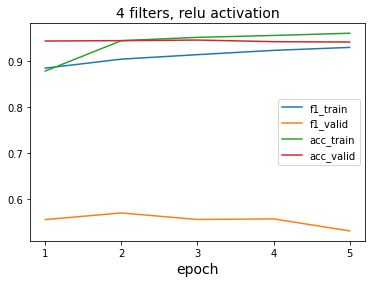

In [234]:
plt.plot(range(5), list(zip(*f1_scores_2))[0], label='f1_train')
plt.plot(range(5), list(zip(*f1_scores_2))[1], label='f1_valid')
plt.plot(range(5), list(zip(*acc_2))[0], label='acc_train')
plt.plot(range(5), list(zip(*acc_2))[1], label='acc_valid')
plt.xlabel('epoch', size=14)
plt.xticks(range(5), range(1, 6))
plt.title('4 filters, relu activation', size=14)
plt.legend()
plt.show()

## ReLU activation, 6 filters, upsampled

In [222]:
m3 = get_model(promoters_embeddins, enhancers_embeddins, n_filters=6)

In [223]:
f1_scores_3 = []
acc_3 = []
for i in range(5):
    history = m3.fit(
                    x=seq_nn_x['train_upsampled'],
                    y=labels_nn['train_upsampled'],
                    validation_data=(seq_nn_x['valid'], labels_nn['valid']),
                    epochs=1, batch_size=8)
    acc_3.append((history.history['acc'], history.history['val_acc']))
    train_pred = m3.predict(seq_nn_x['train_upsampled'])
    valid_pred = m3.predict(seq_nn_x['valid'])
    f1_scores_3.append((
        f1_score(labels_nn['train_upsampled'], train_pred > 0.5 ),
        f1_score(labels_nn['valid'], valid_pred > 0.5)))

Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 232s 7ms/sample - loss: 0.3360 - acc: 0.8764 - val_loss: 0.1472 - val_acc: 0.9467
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 241s 8ms/sample - loss: 0.1790 - acc: 0.9423 - val_loss: 0.1421 - val_acc: 0.9415
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 246s 8ms/sample - loss: 0.1426 - acc: 0.9496 - val_loss: 0.1478 - val_acc: 0.9391
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 234s 7ms/sample - loss: 0.1355 - acc: 0.9518 - val_loss: 0.1443 - val_acc: 0.9450
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 242s 8ms/sample - loss: 0.1273 - acc: 0.9546 - val_loss: 0.1632 - val_acc: 0.9453


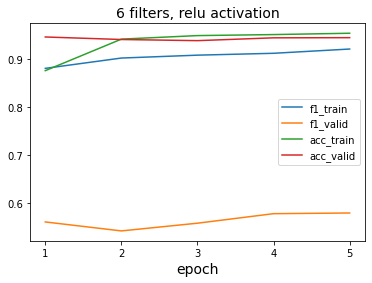

In [233]:
plt.plot(range(5), list(zip(*f1_scores_3))[0], label='f1_train')
plt.plot(range(5), list(zip(*f1_scores_3))[1], label='f1_valid')
plt.plot(range(5), list(zip(*acc_3))[0], label='acc_train')
plt.plot(range(5), list(zip(*acc_3))[1], label='acc_valid')
plt.xlabel('epoch', size=14)
plt.xticks(range(5), range(1, 6))
plt.title('6 filters, relu activation', size=14)
plt.legend()
plt.show()

## Tanh activation, 6 filters, upsampled

In [228]:
m4 = get_model(promoters_embeddins, enhancers_embeddins, n_filters=6, activation='tanh')

In [229]:
f1_scores_4 = []
acc_4 = []
for i in range(5):
    history = m4.fit(
                    x=seq_nn_x['train_upsampled'],
                    y=labels_nn['train_upsampled'],
                    validation_data=(seq_nn_x['valid'], labels_nn['valid']),
                    epochs=1, batch_size=8)
    acc_4.append((history.history['acc'], history.history['val_acc']))
    train_pred = m4.predict(seq_nn_x['train_upsampled'])
    valid_pred = m4.predict(seq_nn_x['valid'])
    f1_scores_4.append((
        f1_score(labels_nn['train_upsampled'], train_pred > 0.5 ),
        f1_score(labels_nn['valid'], valid_pred > 0.5)))

Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 224s 7ms/sample - loss: 0.3083 - acc: 0.8806 - val_loss: 0.1649 - val_acc: 0.9392
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 236s 7ms/sample - loss: 0.1730 - acc: 0.9353 - val_loss: 0.1599 - val_acc: 0.9424
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 244s 8ms/sample - loss: 0.1442 - acc: 0.9464 - val_loss: 0.1553 - val_acc: 0.9451
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 242s 8ms/sample - loss: 0.1365 - acc: 0.9480 - val_loss: 0.1555 - val_acc: 0.9458
Train on 31535 samples, validate on 6253 samples
31535/31535 [==============================] - 235s 7ms/sample - loss: 0.1208 - acc: 0.9556 - val_loss: 0.1796 - val_acc: 0.9367


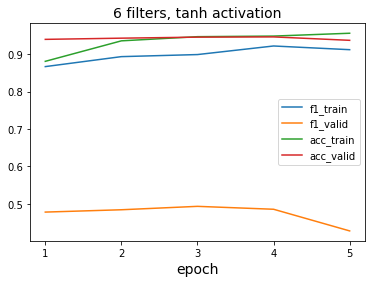

In [232]:
plt.plot(range(5), list(zip(*f1_scores_4))[0], label='f1_train')
plt.plot(range(5), list(zip(*f1_scores_4))[1], label='f1_valid')
plt.plot(range(5), list(zip(*acc_4))[0], label='acc_train')
plt.plot(range(5), list(zip(*acc_4))[1], label='acc_valid')
plt.xlabel('epoch', size=14)
plt.xticks(range(5), range(1, 6))
plt.title('6 filters, tanh activation', size=14)
plt.legend()
plt.show()

# Best NN scores

In [236]:
est_seq = get_model(promoters_embeddins, enhancers_embeddins, n_filters=6)

In [237]:
est_seq.fit(x=seq_nn_x['train_valid_upsampled'],
            y=labels_nn['train_valid_upsampled'],
            epochs=5, batch_size=8)

Epoch 1/5
39457/39457 [==============================] - 278s 7ms/sample - loss: 0.3452 - acc: 0.8608
Epoch 2/5
39457/39457 [==============================] - 292s 7ms/sample - loss: 0.1799 - acc: 0.9368
Epoch 3/5
39457/39457 [==============================] - 269s 7ms/sample - loss: 0.1595 - acc: 0.9440
Epoch 4/5
39457/39457 [==============================] - 290s 7ms/sample - loss: 0.1518 - acc: 0.9452
Epoch 5/5
39457/39457 [==============================] - 326s 8ms/sample - loss: 0.1486 - acc: 0.9475


In [239]:
f1_score(labels_nn['test'],
         est_seq.predict(seq_nn_x['test']) > 0.5)

0.5613305613305614

In [240]:
precision_score(labels_nn['test'], est_seq.predict(seq_nn_x['test']) > 0.5),\
recall_score(labels_nn['test'], est_seq.predict(seq_nn_x['test']) > 0.5)

(0.41411042944785276, 0.8709677419354839)

# Combined NN&TF model

In [243]:
tf_valid_prob = est_tf_trainonly.predict_proba(tf_x['valid'].loc[labels_nn['valid'].index])

In [244]:
nn_seq_valid_prob = m3.predict(seq_nn_x['valid'])

In [409]:
est_combined_seq_nn = GradientBoostingClassifier(learning_rate=0.05, random_state=0,
                                                  n_estimators=20, max_depth=2)
est_combined_seq_nn.fit(np.concatenate((tf_valid_prob, nn_seq_valid_prob), axis=1),
                        labels_nn['valid'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [410]:
test_prob_tf = est_tf.predict_proba(tf_x['test'].loc[labels_nn['test'].index])
test_seq_nn =  est_seq.predict(seq_nn_x['test'])
combined_preds_nn = est_combined_seq_nn.predict(
    np.concatenate((test_prob_tf, test_seq_nn), axis=1)
)

In [411]:
f1_score(labels_nn['test'], combined_preds_nn)

0.8321167883211679

In [412]:
precision_score(labels_nn['test'], combined_preds_nn),\
recall_score(labels_nn['test'], combined_preds_nn)

(0.957983193277311, 0.7354838709677419)

In [413]:
f1_score(labels_nn['test'], test_prob_tf[:, 1] > 0.5), f1_score(labels_nn['test'], test_seq_nn > 0.5)

(0.8445945945945944, 0.5613305613305614)

In [414]:
precision_score(labels_nn['test'], test_prob_tf[:, 1] > 0.5),\
precision_score(labels_nn['test'], test_seq_nn > 0.5)

(0.8865248226950354, 0.41411042944785276)

In [415]:
recall_score(labels_nn['test'], test_prob_tf[:, 1] > 0.5),\
recall_score(labels_nn['test'], test_seq_nn > 0.5)

(0.8064516129032258, 0.8709677419354839)